In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.stats import kurtosis, skew
from scipy.signal import welch
from scipy.integrate import simps
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    return data

In [ ]:
files = [f"s{str(i).zfill(2)}.dat" for i in range(1, 33)]
print(files)

data_list = []
labels_list = []

data_path = "/content/drive/My Drive/EEG/"

['s01.dat', 's02.dat', 's03.dat', 's04.dat', 's05.dat', 's06.dat', 's07.dat', 's08.dat', 's09.dat', 's10.dat', 's11.dat', 's12.dat', 's13.dat', 's14.dat', 's15.dat', 's16.dat', 's17.dat', 's18.dat', 's19.dat', 's20.dat', 's21.dat', 's22.dat', 's23.dat', 's24.dat', 's25.dat', 's26.dat', 's27.dat', 's28.dat', 's29.dat', 's30.dat', 's31.dat', 's32.dat']


In [ ]:
for file in files:
    full_path = data_path + file
    file_data = read_data(full_path)
    data_list.append(file_data['data'])
    labels_list.append(file_data['labels'])

data_array = np.array(data_list)
labels_array = np.array(labels_list)

print("Data shape:", data_array.shape)
print("Labels shape:", labels_array.shape)


Data shape: (32, 40, 40, 8064)
Labels shape: (32, 40, 4)


In [ ]:
eeg_data = data_array[:, :, :32, :]
eeg_data = eeg_data.reshape(-1, 32, 8064)
labels = labels_array.reshape(-1, 4)

print("EEG Data shape:", eeg_data.shape)
print("Labels shape:", labels.shape)

EEG Data shape: (1280, 32, 8064)
Labels shape: (1280, 4)


In [ ]:
print("EEG Data Min:", np.min(eeg_data))
print("EEG Data Max:", np.max(eeg_data))
print("Label Ranges:")
print("Valence:", labels[:, 0].min(), "-", labels[:, 0].max())
print("Arousal:", labels[:, 1].min(), "-", labels[:, 1].max())
print("Dominance:", labels[:, 2].min(), "-", labels[:, 2].max())
print("Liking:", labels[:, 3].min(), "-", labels[:, 3].max())

EEG Data Min: -2656.4252330049085
EEG Data Max: 2843.9056801961733
Label Ranges:
Valence: 1.0 - 9.0
Arousal: 1.0 - 9.0
Dominance: 1.0 - 9.0
Liking: 1.0 - 9.0


In [ ]:
def calculate_statistical_features(data):
    mean = np.mean(data, axis=1)
    std_dev = np.std(data, axis=1)
    skewness = skew(data, axis=1)
    kurt = kurtosis(data, axis=1)
    features = np.vstack((mean, std_dev, skewness, kurt)).T
    return features

stat_features = []

for trial in eeg_data:
    trial_features = calculate_statistical_features(trial)
    stat_features.append(trial_features.flatten())

stat_features = np.array(stat_features)

print("Statistical Features Shape:", stat_features.shape)

Statistical Features Shape: (1280, 128)


In [ ]:
def bandpower(data, sf, band):
    band = np.asarray(band)
    low, high = band
    nperseg = (2 / low) * sf
    freqs, psd = welch(data, sf, nperseg=int(nperseg))
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = simps(psd[idx_band], dx=freq_res)
    return bp

In [ ]:
sf = 128
bands = {"Delta": (0.5, 4), "Theta": (4, 8), "Alpha": (8, 12), "Beta": (12, 30), "Gamma": (30, 64)}
band_features = []

In [ ]:
for trial in eeg_data:
    trial_band_features = []
    for channel in trial:
        channel_features = [bandpower(channel, sf, band) for band in bands.values()]
        trial_band_features.extend(channel_features)
    band_features.append(trial_band_features)

band_features = np.array(band_features)
print("Band Power Features Shape:", band_features.shape)

<ipython-input-46-5b118b003726>:8: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  bp = simps(psd[idx_band], dx=freq_res)


Band Power Features Shape: (1280, 160)


In [ ]:
features = np.hstack((stat_features, band_features))
print("Combined Features Shape:", features.shape)

Combined Features Shape: (1280, 288)


In [ ]:
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)
print("Mean of features after normalization (per feature):", normalized_features.mean(axis=0)[:5])
print("Std of features after normalization (per feature):", normalized_features.std(axis=0)[:5])

Mean of features after normalization (per feature): [-2.84060969e-18  4.80952084e-16  1.63324215e-16  6.29704622e-17
 -9.03682511e-18]
Std of features after normalization (per feature): [1. 1. 1. 1. 1.]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(normalized_features, labels, test_size=0.2, random_state=42)

print("Training Set Shape:", X_train.shape, y_train.shape)
print("Testing Set Shape:", X_test.shape, y_test.shape)

Training Set Shape: (1024, 288) (1024, 4)
Testing Set Shape: (256, 288) (256, 4)


In [ ]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVM": SVC(kernel='rbf', C=1.0),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
}

In [ ]:
label_index = 0
binary_labels = (labels[:, label_index] > 5).astype(int)
y_train, y_test = train_test_split(binary_labels, test_size=0.2, random_state=42)

print("Label Distribution in Training Set:", np.bincount(y_train))
print("Label Distribution in Testing Set:", np.bincount(y_test))

Label Distribution in Training Set: [462 562]
Label Distribution in Testing Set: [110 146]


In [ ]:
valence_train_accuracies = []
valence_test_accuracies = []

In [ ]:
print("Valence Model:")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    valence_train_accuracies.append(train_acc)
    valence_test_accuracies.append(test_acc)
    print(f"{name} - Training Accuracy: {train_acc:.3f}, Testing Accuracy: {test_acc:.3f}")

Valence Model:
KNN - Training Accuracy: 0.713, Testing Accuracy: 0.562
SVM - Training Accuracy: 0.646, Testing Accuracy: 0.566
Decision Tree - Training Accuracy: 0.937, Testing Accuracy: 0.496
Random Forest - Training Accuracy: 0.993, Testing Accuracy: 0.609


In [ ]:
model_names = list(models.keys())
bar_width = 0.2
x = np.arange(len(model_names))

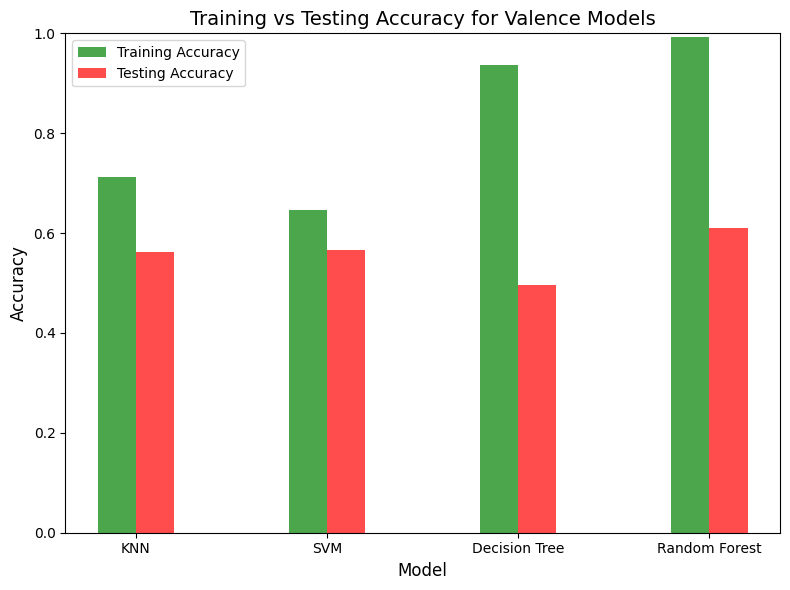

In [66]:
plt.figure(figsize=(8, 6))
plt.bar(x - bar_width / 2, valence_train_accuracies, bar_width, label='Training Accuracy', color='green', alpha=0.7)
plt.bar(x + bar_width / 2, valence_test_accuracies, bar_width, label='Testing Accuracy', color='red', alpha=0.7)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training vs Testing Accuracy for Valence Models', fontsize=14)
plt.xticks(x, model_names)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
label_index = 1
binary_labels = (labels[:, label_index] > 5).astype(int)
y_train, y_test = train_test_split(binary_labels, test_size=0.2, random_state=42)

print("Label Distribution in Training Set:", np.bincount(y_train))
print("Label Distribution in Testing Set:", np.bincount(y_test))

Label Distribution in Training Set: [436 588]
Label Distribution in Testing Set: [107 149]


In [ ]:
arousal_train_accuracies = []
arousal_test_accuracies = []

In [ ]:
print("Arousal Model:")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    arousal_train_accuracies.append(train_acc)
    arousal_test_accuracies.append(test_acc)
    print(f"{name} - Training Accuracy: {train_acc:.3f}, Testing Accuracy: {test_acc:.3f}")

Arousal Model:
KNN - Training Accuracy: 0.712, Testing Accuracy: 0.594
SVM - Training Accuracy: 0.683, Testing Accuracy: 0.586
Decision Tree - Training Accuracy: 0.896, Testing Accuracy: 0.594
Random Forest - Training Accuracy: 0.989, Testing Accuracy: 0.582


In [ ]:
model_names = list(models.keys())
bar_width = 0.2
x = np.arange(len(model_names))

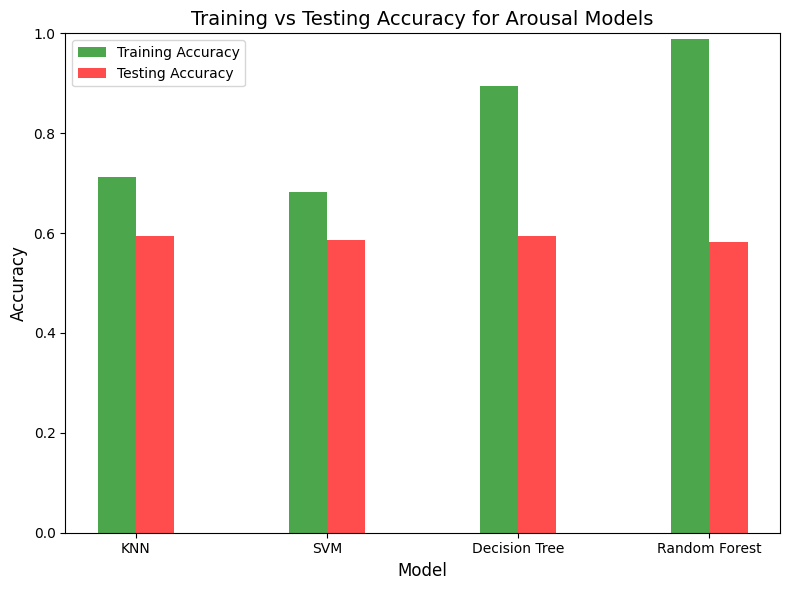

In [65]:
plt.figure(figsize=(8, 6))
plt.bar(x - bar_width / 2, arousal_train_accuracies, bar_width, label='Training Accuracy', color='green', alpha=0.7)
plt.bar(x + bar_width / 2, arousal_test_accuracies, bar_width, label='Testing Accuracy', color='red', alpha=0.7)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training vs Testing Accuracy for Arousal Models', fontsize=14)
plt.xticks(x, model_names)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()